# Scale and bond-length statistics
Compute bond-length distributions and RMS before/after scaling for `data/train`.


In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from scripts.dataloader import HiCStructureDataset
from scripts.preprocess import center_batch, scale_batch, COORD_IDX, MASK_IDX

device = torch.device("cpu")

dataset = HiCStructureDataset(root_dir="data/train")
struct_paths = [s for _, s in dataset.samples]
len(struct_paths)


Found 37500 samples in dataset.


37500

In [2]:
coord_idx = torch.tensor(COORD_IDX, device=device)
mask_idx = torch.tensor(MASK_IDX, device=device)

def flatten_coords(struct_batch: torch.Tensor):
    coords = struct_batch[..., coord_idx]
    masks = struct_batch[..., mask_idx]
    coords_3d = coords.view(struct_batch.shape[0], -1, 3)
    valid = masks.repeat_interleave(3, dim=-1).view(struct_batch.shape[0], -1, 3)[..., 0] > 0.5
    return coords_3d, valid

def bond_lengths(struct_batch: torch.Tensor):
    coords_3d, valid = flatten_coords(struct_batch)
    diffs = coords_3d[:, 1:, :] - coords_3d[:, :-1, :]
    valid_pairs = valid[:, 1:] & valid[:, :-1]
    lengths = torch.linalg.norm(diffs, dim=-1)
    return lengths[valid_pairs]

def rms_from_lengths(lengths: torch.Tensor) -> float:
    return torch.sqrt(torch.mean(lengths ** 2)).item()


In [3]:
center_lengths = []
scaled_lengths = []
center_norms = []
scaled_norms = []

with torch.no_grad():
    for struct_path in tqdm(struct_paths, desc="One-pass stats"):
        struct = dataset._load_structure_seq(struct_path).unsqueeze(0).to(device)
        centered, _ = center_batch(struct)

        coords_c, valid_c = flatten_coords(centered)
        norms_c = torch.linalg.norm(coords_c, dim=-1)
        valid_norms_c = norms_c[valid_c]
        if valid_norms_c.numel() > 0:
            center_norms.append(valid_norms_c.cpu())

        l_center = bond_lengths(centered)
        if l_center.numel() > 0:
            center_lengths.append(l_center.cpu())

        scaled, _ = scale_batch(centered)

        coords_s, valid_s = flatten_coords(scaled)
        norms_s = torch.linalg.norm(coords_s, dim=-1)
        valid_norms_s = norms_s[valid_s]
        if valid_norms_s.numel() > 0:
            scaled_norms.append(valid_norms_s.cpu())

        l_scaled = bond_lengths(scaled)
        if l_scaled.numel() > 0:
            scaled_lengths.append(l_scaled.cpu())

center_lengths = torch.cat(center_lengths)
scaled_lengths = torch.cat(scaled_lengths)
center_norms = torch.cat(center_norms)
scaled_norms = torch.cat(scaled_norms)

center_rms = rms_from_lengths(center_lengths)
scaled_rms = rms_from_lengths(scaled_lengths)
center_norm_rms = rms_from_lengths(center_norms)
scaled_norm_rms = rms_from_lengths(scaled_norms)

(center_lengths.numel(), scaled_lengths.numel(), center_norms.numel(), scaled_norms.numel(), center_rms, scaled_rms, center_norm_rms, scaled_norm_rms)


One-pass stats: 100%|██████████| 37500/37500 [55:38<00:00, 11.23it/s] 


(70436066,
 70436066,
 104831805,
 104831805,
 11.146160125732422,
 1.15251624584198,
 9.74427318572998,
 1.0)

In [4]:
import numpy as np
from scipy.stats import rayleigh, kstest

def _rayleigh_fit_and_test(x: np.ndarray):
    if x.size == 0:
        return None, None, None
    sigma = np.sqrt(np.mean(x ** 2) / 2.0)
    dist = rayleigh(loc=0.0, scale=sigma)
    res = kstest(x, dist.cdf)
    return sigma, res.statistic, res.pvalue

center_sigma, center_ks, center_p = _rayleigh_fit_and_test(center_lengths.numpy())
scaled_sigma, scaled_ks, scaled_p = _rayleigh_fit_and_test(scaled_lengths.numpy())

print(f"Bond lengths (centered): sigma={center_sigma:.4f}, KS={center_ks:.4f}, p={center_p:.4e}")
print(f"Bond lengths (scaled):   sigma={scaled_sigma:.4f}, KS={scaled_ks:.4f}, p={scaled_p:.4e}")


Bond lengths (centered): sigma=7.8815, KS=0.1843, p=0.0000e+00
Bond lengths (scaled):   sigma=0.8150, KS=0.1852, p=0.0000e+00


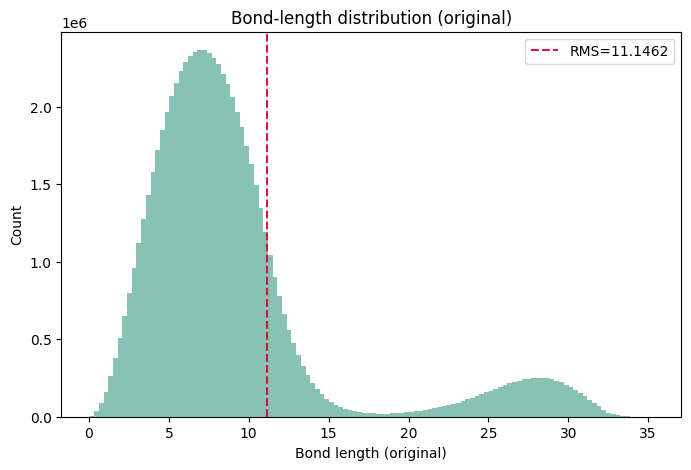

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(center_lengths.numpy(), bins=120, color="#69b3a2", alpha=0.8)
ax.axvline(center_rms, color="crimson", linestyle="--", label=f"RMS={center_rms:.4f}")
ax.set_xlabel("Bond length (original)")
ax.set_ylabel("Count")
ax.set_title("Bond-length distribution (original)")
ax.legend()
plt.show()


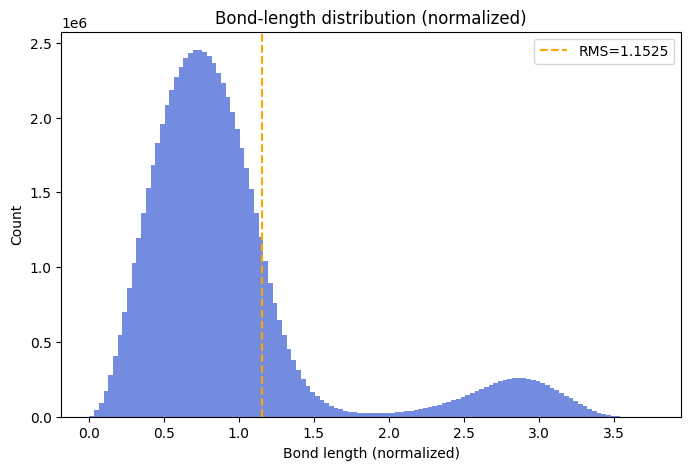

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(scaled_lengths.numpy(), bins=120, color="#5170d7", alpha=0.8)
ax.axvline(scaled_rms, color="orange", linestyle="--", label=f"RMS={scaled_rms:.4f}")
ax.set_xlabel("Bond length (normalized)")
ax.set_ylabel("Count")
ax.set_title("Bond-length distribution (normalized)")
ax.legend()
plt.show()


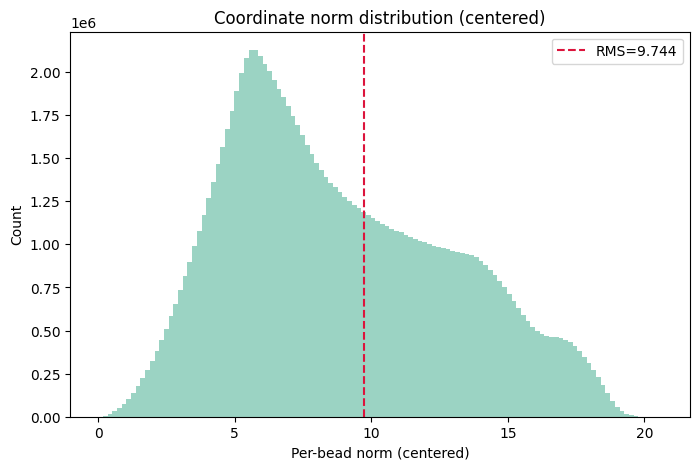

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(center_norms.numpy(), bins=120, color="#82c8b4", alpha=0.8)
ax.axvline(center_norm_rms, color="crimson", linestyle="--", label=f"RMS={center_norm_rms:.3f}")
ax.set_xlabel("Per-bead norm (centered)")
ax.set_ylabel("Count")
ax.set_title("Coordinate norm distribution (centered)")
ax.legend()
plt.show()


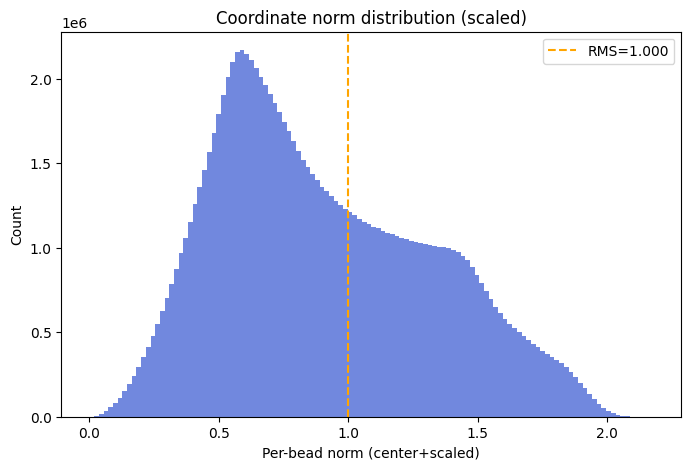

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(scaled_norms.numpy(), bins=120, color="#4e6bd6", alpha=0.8)
ax.axvline(scaled_norm_rms, color="orange", linestyle="--", label=f"RMS={scaled_norm_rms:.3f}")
ax.set_xlabel("Per-bead norm (center+scaled)")
ax.set_ylabel("Count")
ax.set_title("Coordinate norm distribution (scaled)")
ax.legend()
plt.show()
